## Random Forest Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [26]:
# read dataset without summaries
df = pd.read_csv("movies.csv")
df = df.astype({'Date':'int16', 'Certificate': 'category', 'Votes': 'int64','IMDB':'float16', 
                'Metascore':'float16', 'Genre':'category'})
df = df.drop(['Unnamed: 0'],axis=1)
# split train and test data
X1 = df.iloc[:, 2:-1]

# encode categorical variables
X1 = X1.astype({'Director': 'category', 'Star1': 'category','Star2':'category', 'Star3':'category', 'Star4':'category'})
X1['Certificate'] = X1['Certificate'].cat.codes
X1['Director'] = X1['Director'].cat.codes
X1['Star1'] = X1['Star1'].cat.codes
X1['Star2'] = X1['Star2'].cat.codes
X1['Star3'] = X1['Star3'].cat.codes
X1['Star4'] = X1['Star4'].cat.codes

# encode classes
y1 = df.iloc[:, -2]
y1 = pd.factorize(y1)

# build random forest on dataset
rf1 = RandomForestRegressor(n_estimators=X1.shape[1])
# fit the random forest
rf1.fit(X1, y1[0])

RandomForestRegressor(n_estimators=10)

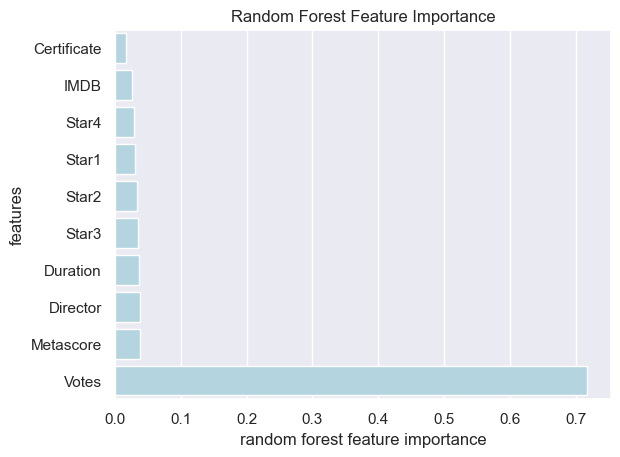

In [27]:
# extract feature importances and save in a dataframe
feature_importance = pd.DataFrame(list(zip(X1.columns,rf1.feature_importances_)), columns =['name', 'val'])
# sort importances
feature_importance.sort_values(by='val', inplace=True)
# plot the importnace of each feature
ax = sns.barplot(x=feature_importance['val'], y=feature_importance['name'], color="lightblue")
ax.set(xlabel='random forest feature importance', ylabel='features', title='Random Forest Feature Importance');

## EDA

In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import plotly.express as px 
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

In [5]:
# description of numerical variables
df.describe()

Date     Duration         Votes         IMDB    Metascore
count  1000.000000  1000.000000  1.000000e+03  1000.000000  1000.000000
mean   1991.424000   123.985000  3.084493e+05     7.968750          inf
std      24.067311    28.687624  3.730340e+05     0.277100    11.023438
min    1920.000000    45.000000  2.558900e+04     7.601562    28.000000
25%    1975.000000   103.000000  5.952450e+04     7.800781    73.000000
50%    1999.000000   120.000000  1.516130e+05     7.898438    80.000000
75%    2010.000000   138.000000  4.273335e+05     8.101562    86.000000
max    2022.000000   321.000000  2.679921e+06     9.296875   100.000000

In [6]:
# dataframe quick overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         1000 non-null   object  
 1   Date         1000 non-null   int16   
 2   Certificate  1000 non-null   category
 3   Duration     1000 non-null   int64   
 4   Votes        1000 non-null   int64   
 5   IMDB         1000 non-null   float16 
 6   Metascore    1000 non-null   float16 
 7   Director     1000 non-null   object  
 8   Star1        1000 non-null   object  
 9   Star2        1000 non-null   object  
 10  Star3        1000 non-null   object  
 11  Star4        1000 non-null   object  
 12  Genre        1000 non-null   category
dtypes: category(2), float16(2), int16(1), int64(2), object(6)
memory usage: 71.5+ KB


### Exploratory Data Analysis for categorical variable:

In [7]:
# !pip install squarify

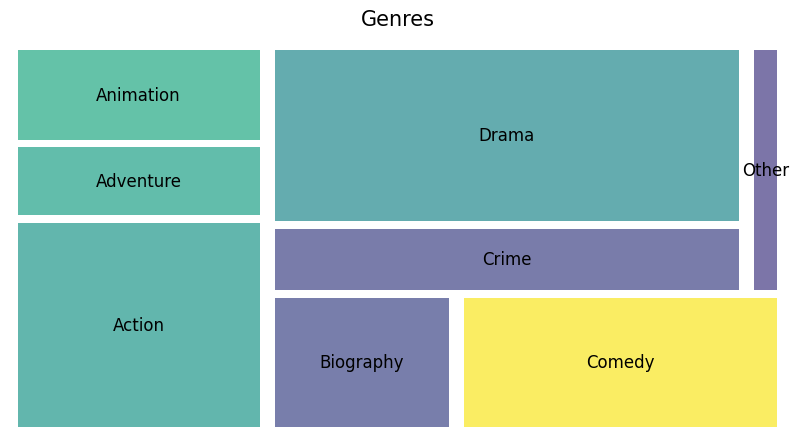

In [8]:
import squarify
# frequncy of each genre in the dataset
genres_flatten = df.groupby('Genre').count()["Name"]
genres_info = df.groupby('Genre').count()["Name"]
genres_info = df.groupby('Genre').count()["Name"]
plt.figure(figsize= (10, 5))
plt.title("Genres", fontsize=15, pad=15)
squarify.plot (genres_info,\
               label=genres_info.keys(), text_kwargs={'fontsize': 12}, bar_kwargs={'alpha': .7}, pad=True)
plt.axis ("off");

In [21]:
num_columns = ['Duration', 'Votes', 'Metascore', 'IMDB']

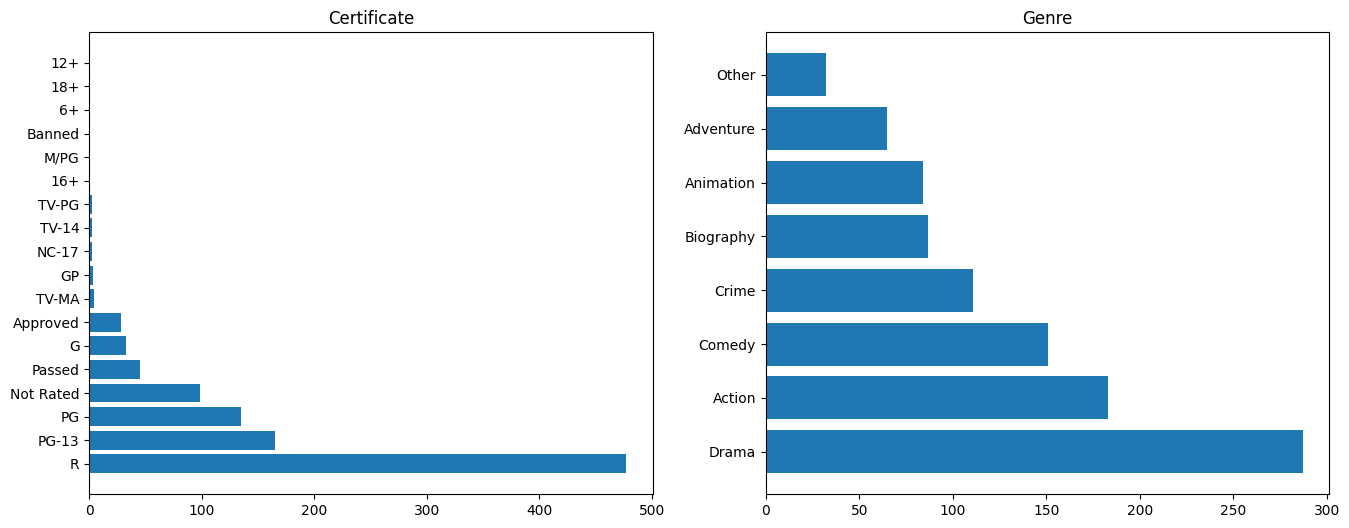

In [10]:
# plotting frequency of each genre and each certificate group
cat_columns = ['Certificate', 'Genre']
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16, 6))
counter = 0

for cat_column in cat_columns:
    value_counts = df[cat_column].value_counts()  
    trace_y = counter % 2
    x_pos = np.arange(0, len(value_counts))
    axs[trace_y].barh(x_pos, value_counts.values, tick_label = value_counts.index)
    axs[trace_y].set_title(cat_column)
    counter += 1

plt.show()

From the plots above, it can be infered that the most frequent and maybe popular genre is drama and after that action movies are so common.
Most of the movies has R certificate.

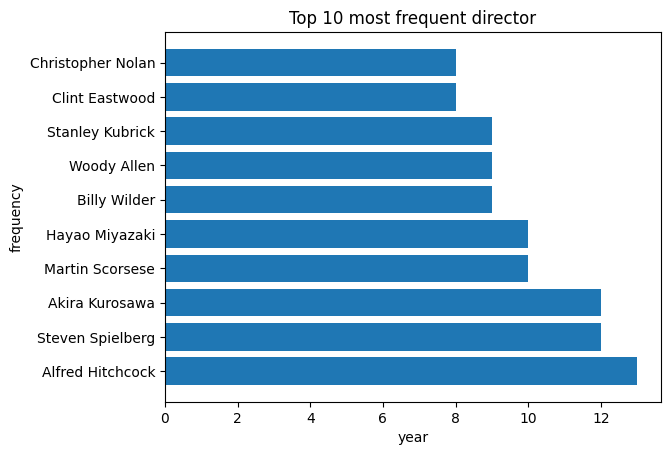

In [11]:
# Most frequent directors in the dataset
value_counts = df["Director"].value_counts()[:10]
x_pos = np.arange(0, len(value_counts))
    
plt.barh(x_pos, value_counts.values, tick_label = value_counts.index)
plt.title("Top 10 most frequent director")
plt.xlabel("year")
plt.ylabel("frequency")
plt.show()

This plot shows the top 10 most frequent director in the dataset. As you see, the most frequent movies belongs to Alfred Hitchcock with 13 movies.

Here, to get top 10 most frequent stars, all 3 columns that are related to stars, were considered. As the plot shows, the most repeated star is Robert De Niro.

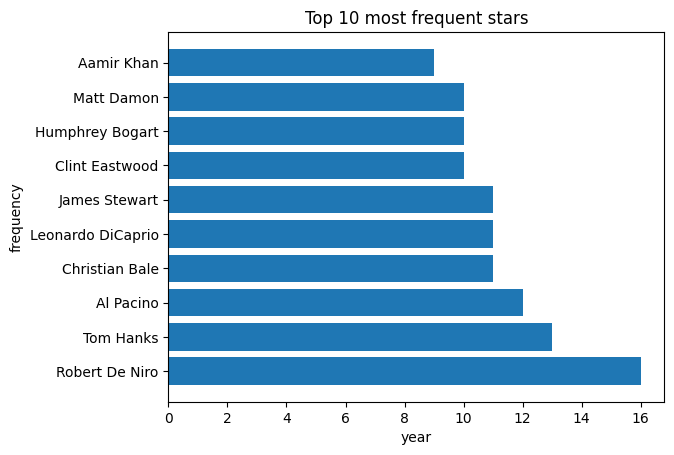

In [12]:
# in order to find the most frequent stars in the datasest, despite of star1,2 or 3, the columns should be joined 
value_counts = pd.DataFrame(np.array(df[["Star1", "Star2", "Star3"]]).flatten()).value_counts()[:10]
x_pos = np.arange(0, len(value_counts))
    
labels = []
for i in value_counts.index:
    labels.append(i[0])
    
plt.barh(x_pos, value_counts.values, tick_label = labels)
plt.title("Top 10 most frequent stars")
plt.xlabel("year")
plt.ylabel("frequency")
plt.show()

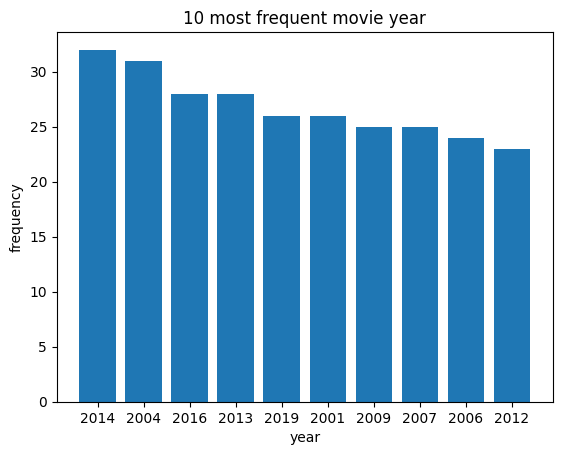

In [13]:
# which year has the most top film productions
value_counts = df["Date"].value_counts()[:10]
x_pos = np.arange(0, len(value_counts))
    
plt.bar(x_pos, value_counts.values, tick_label = value_counts.index)
plt.title("10 most frequent movie year")
plt.xlabel("year")
plt.ylabel("frequency")
plt.show()

Here is another EDA for numerical variables in the dataset using box plots:

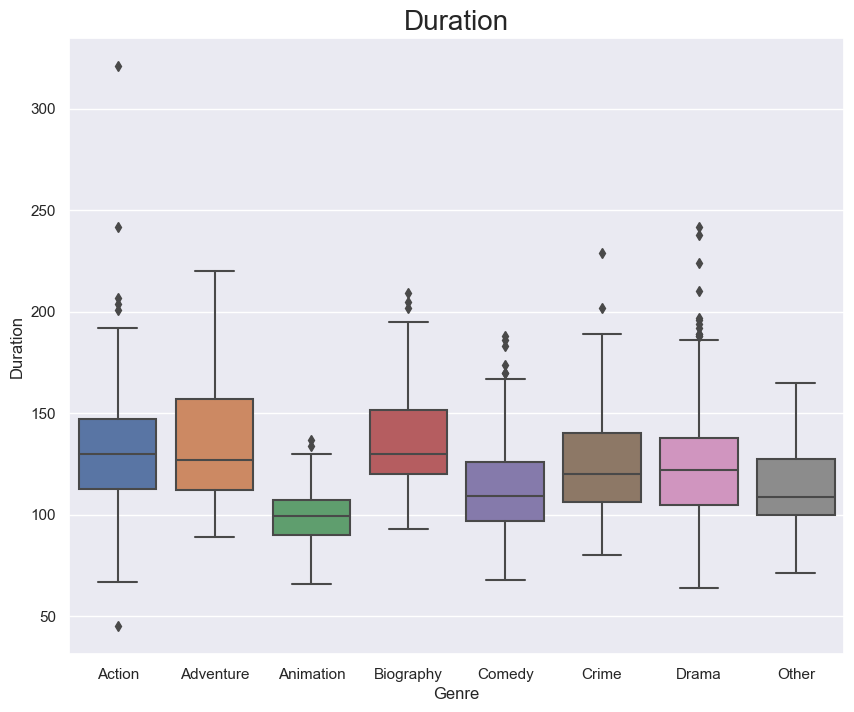

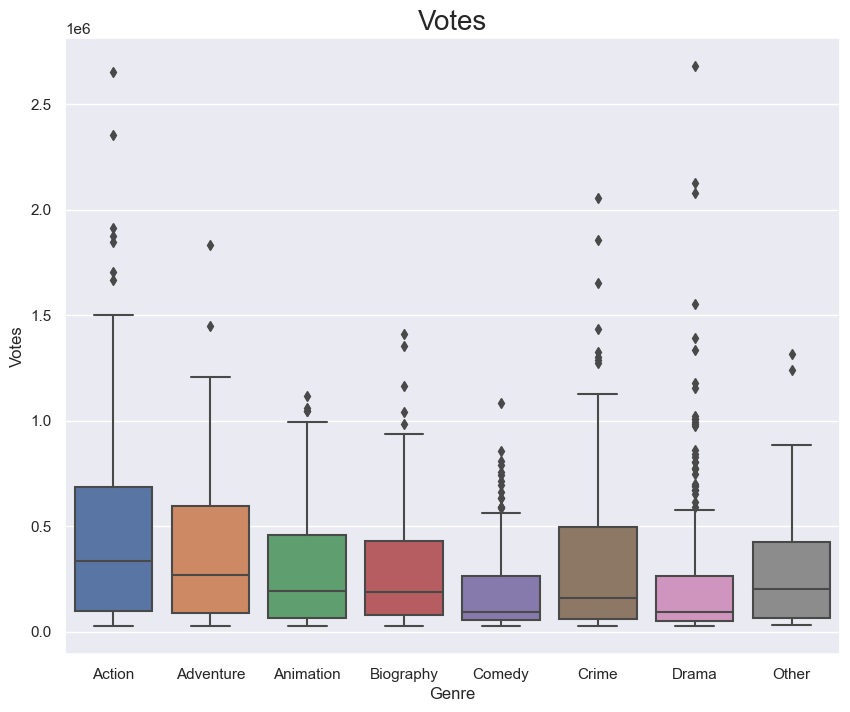

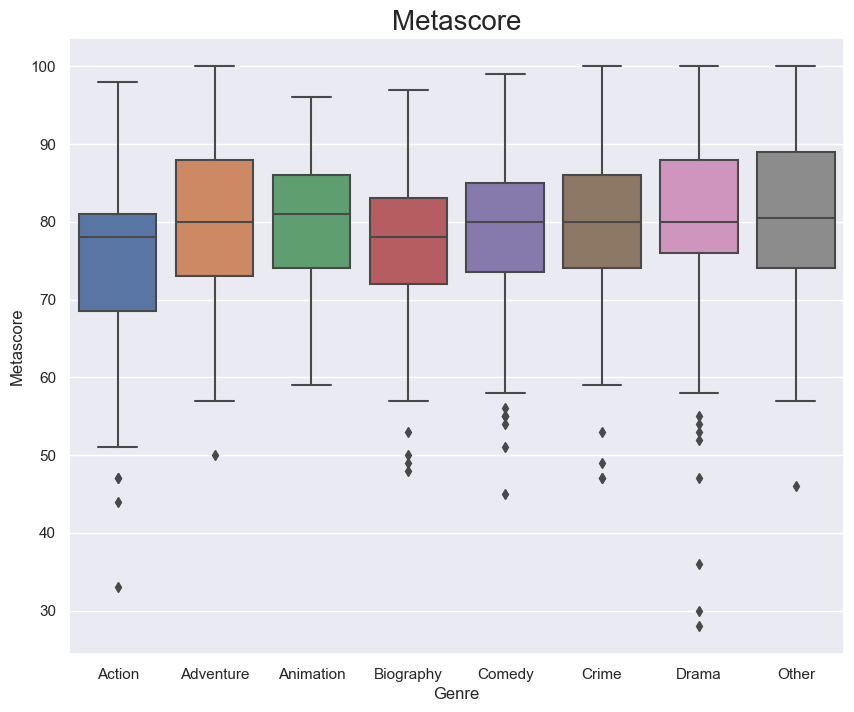

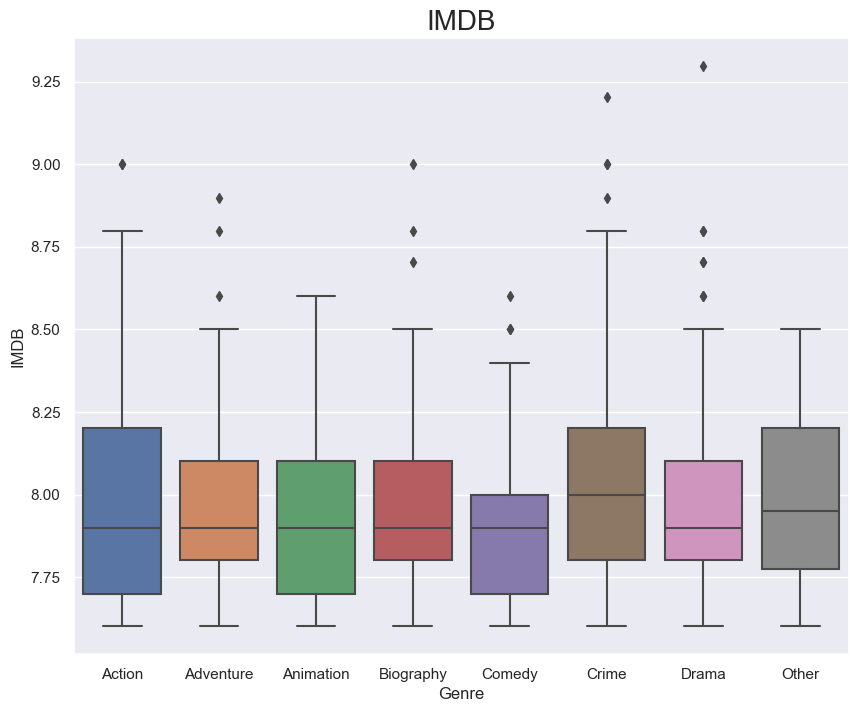

In [32]:
# distribution of numerical variables in each genre
y1 = df['Genre']

for i in num_columns:
    plt.figure(figsize=(10,8))
    b = sns.boxplot(x = y1,y = i,data = df)
    b.axes.set_title(i, fontsize=20)
    plt.show();

### Exploratory Data Analysis for numerical variable:

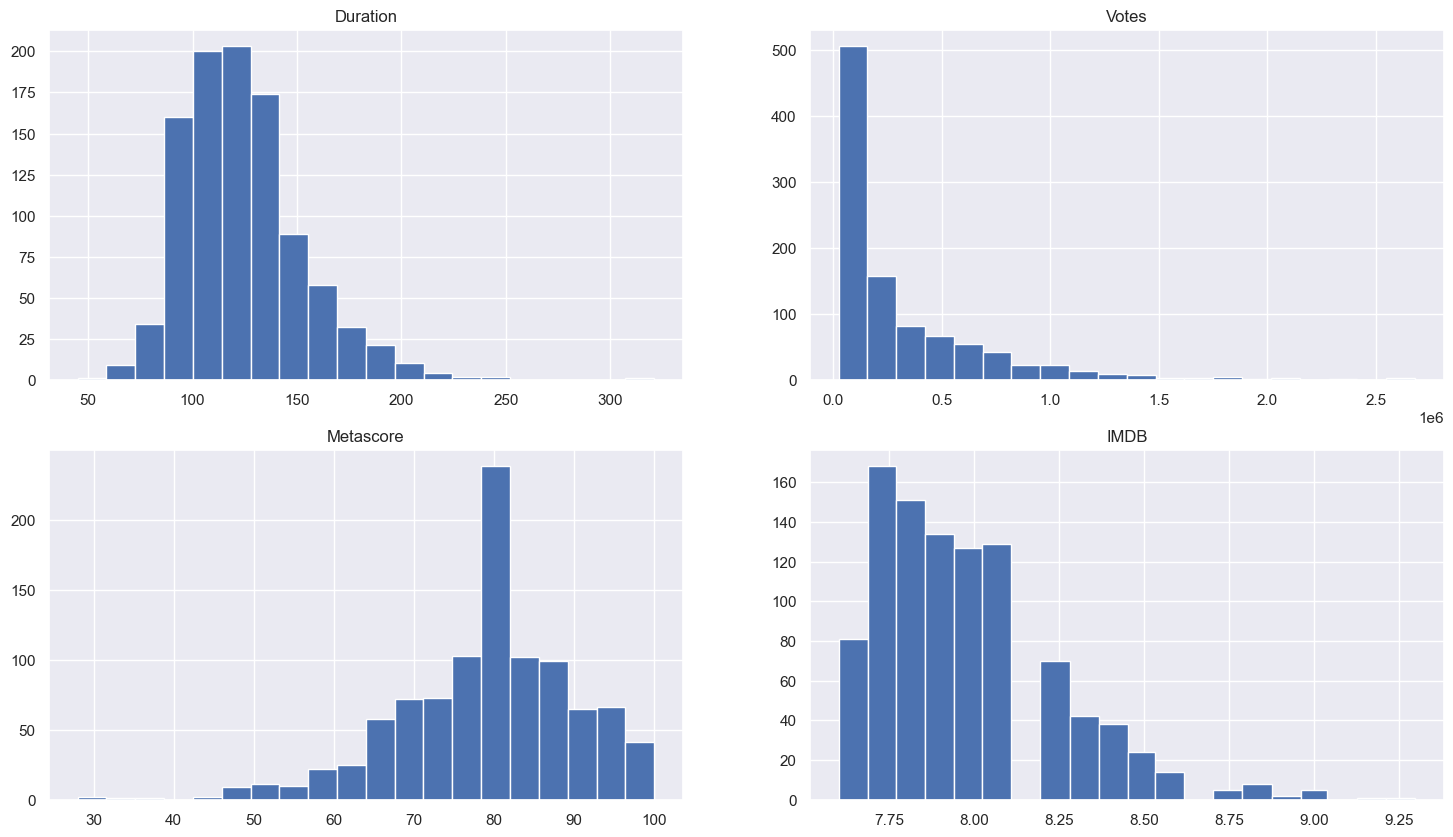

In [22]:
# distribution of numerical features
fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(18, 10))

counter = 0
for num_column in num_columns:
    trace_x = counter // 2
    trace_y = counter % 2
    axs[trace_x, trace_y].hist(df[num_column], bins=20)
    axs[trace_x, trace_y].set_title(num_column)
    counter += 1

plt.show()

The correlation between numerical features in the dataset is as follows:

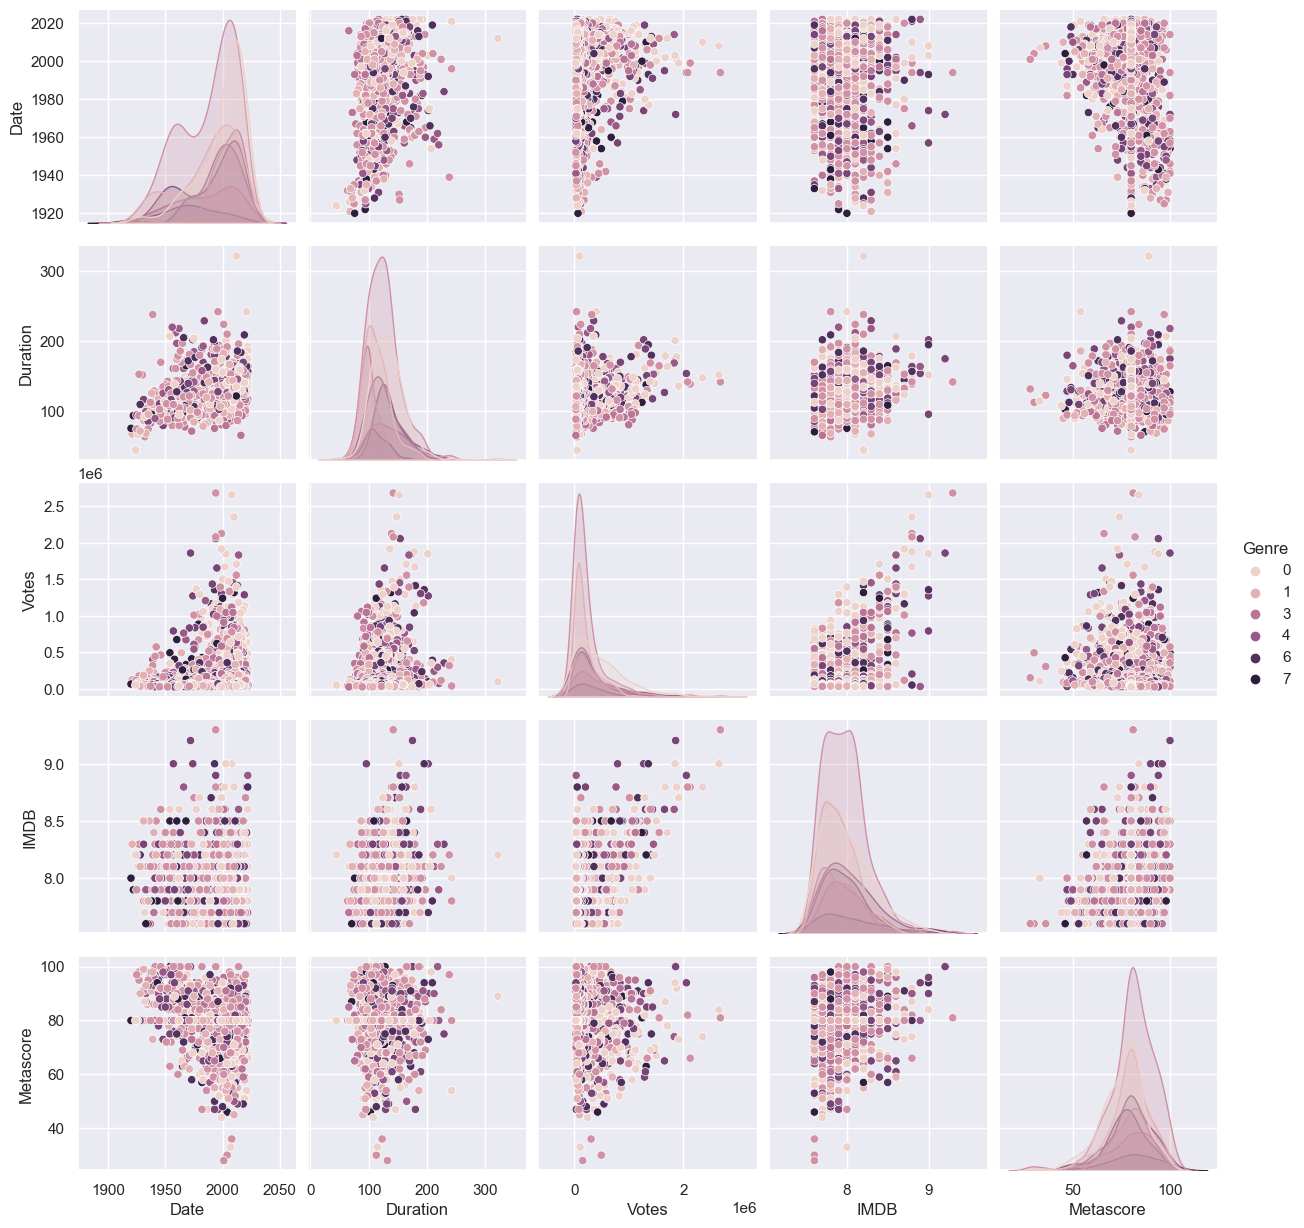

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

#create pairs plot for all numeric variables
sns.pairplot(df, hue='Genre');

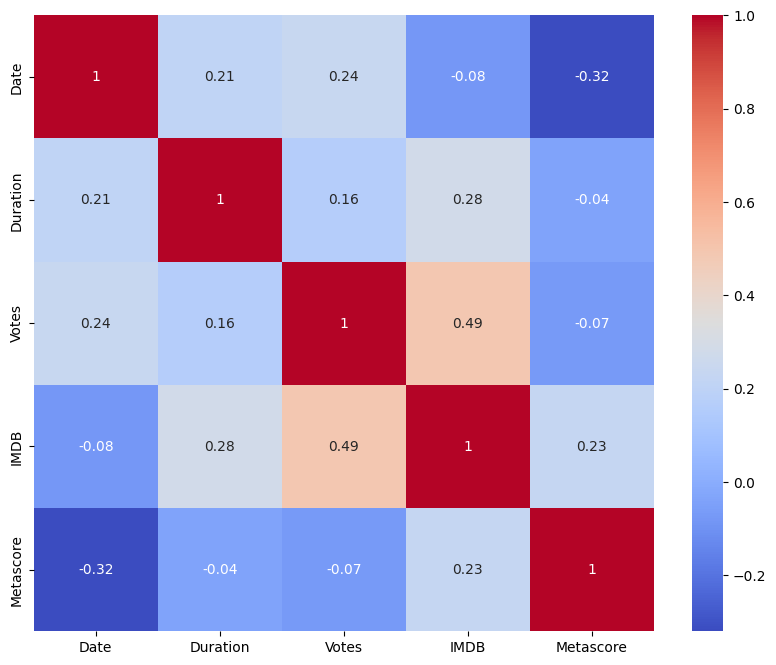

In [16]:
plt.figure(figsize=(10,8))
c= df.corr().round(2)
sns.heatmap(c, cmap="coolwarm",annot=True);

## Dimension Reduction

### PCA

In [17]:
gen = pd.factorize(df['Genre'])
df['Genre'] = gen[0]

In [18]:
#converting the categorical features to numerical value using pandas built-in function
df1 = pd.get_dummies(df)

# perform PCA on features after standardizing data
scaler = StandardScaler()
X = scaler.fit_transform(df1)
pca = PCA(n_components=2) 
components = pca.fit_transform(X) 
fig = px.scatter(components, x=0, y=1, color=df1['Genre']) 
fig.show()

### LDA

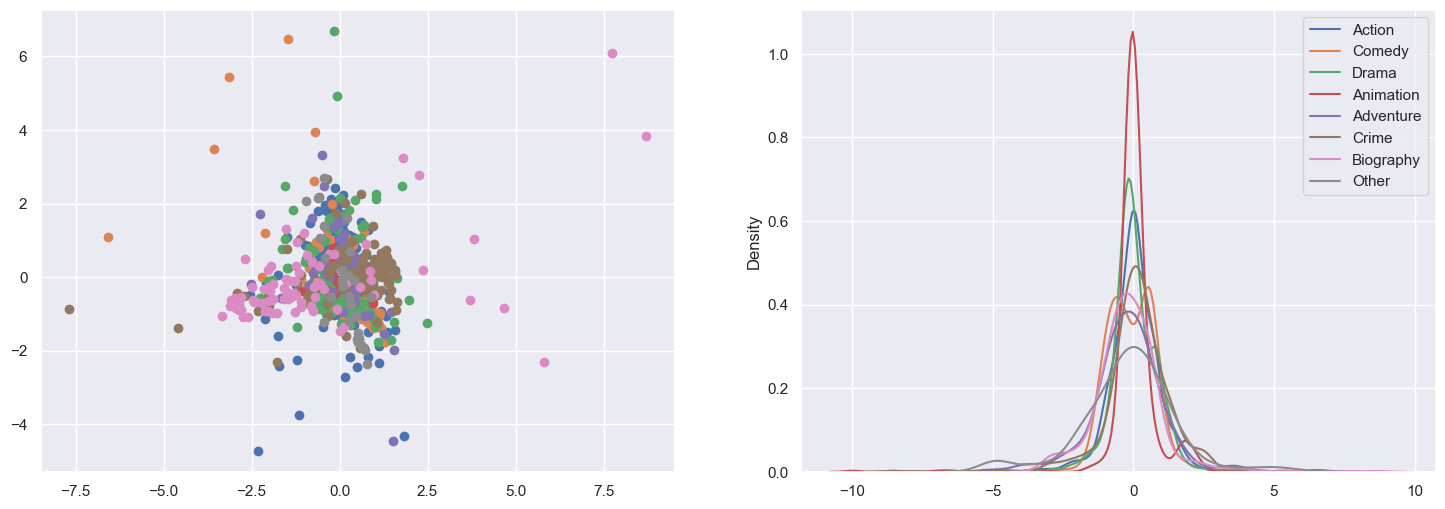

In [19]:
sns.set()
# getting columns to reduce
columns = df1.columns.tolist()
columns.remove('Genre')
X = df1[columns]
y = df1['Genre']

# performing LDA
model = LinearDiscriminantAnalysis()
X_lda = model.fit(X, y).transform(X)

genres = np.unique(df['Genre'])

fig, axes = plt.subplots(1,2, figsize=(18,6))

for g in genres:
    mask = (y == g)
    axes[0].scatter(x=X_lda[mask,0],y=X_lda[mask,1], label=g)

for g in genres:
    mask = (y == g)
    sns.kdeplot(np.ravel(X_lda[mask]), ax=axes[1], label=gen[1][g])
axes[1].legend()
plt.show()